In [1]:
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn import preprocessing
import logistic_regression as lr
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp
import seaborn as sns

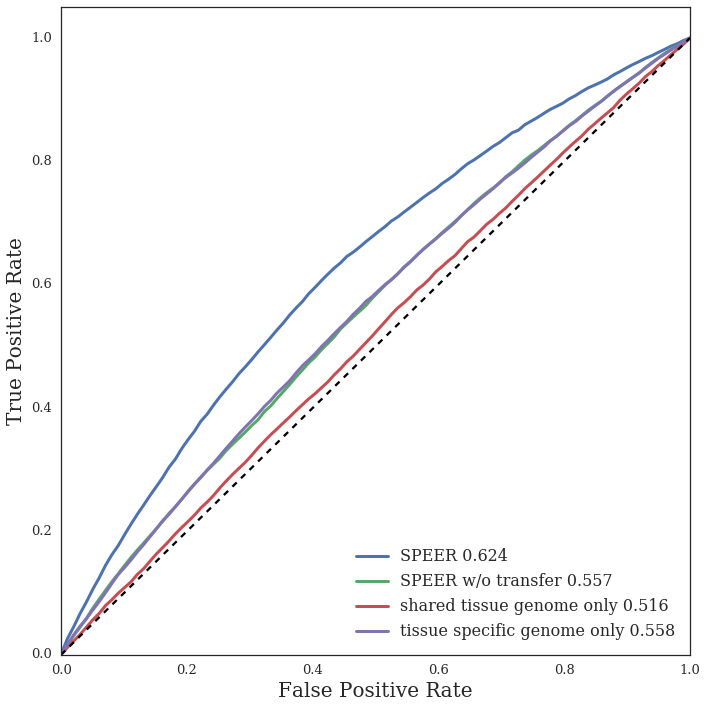

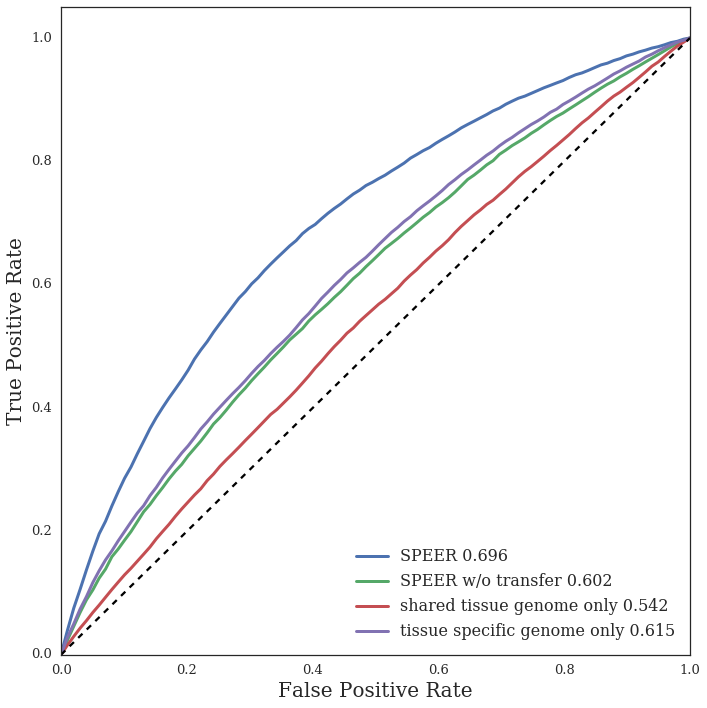

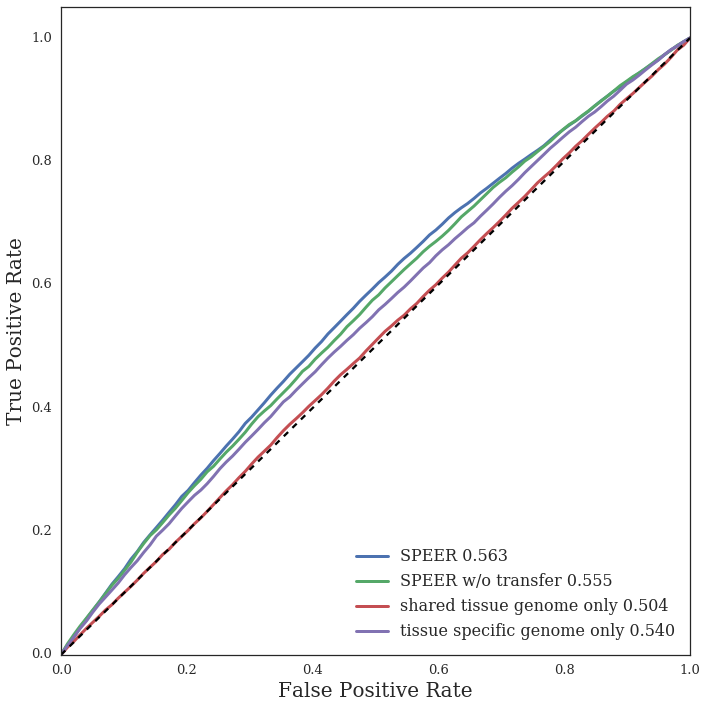

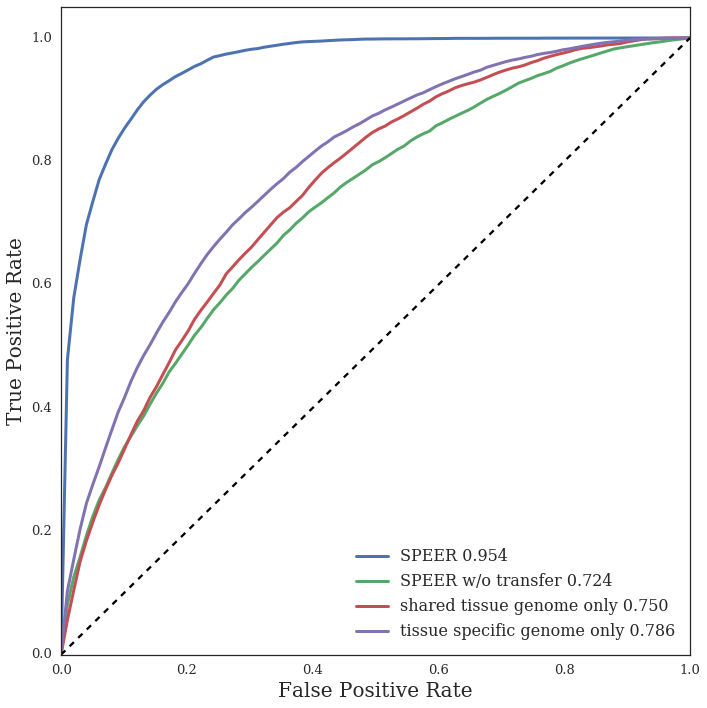

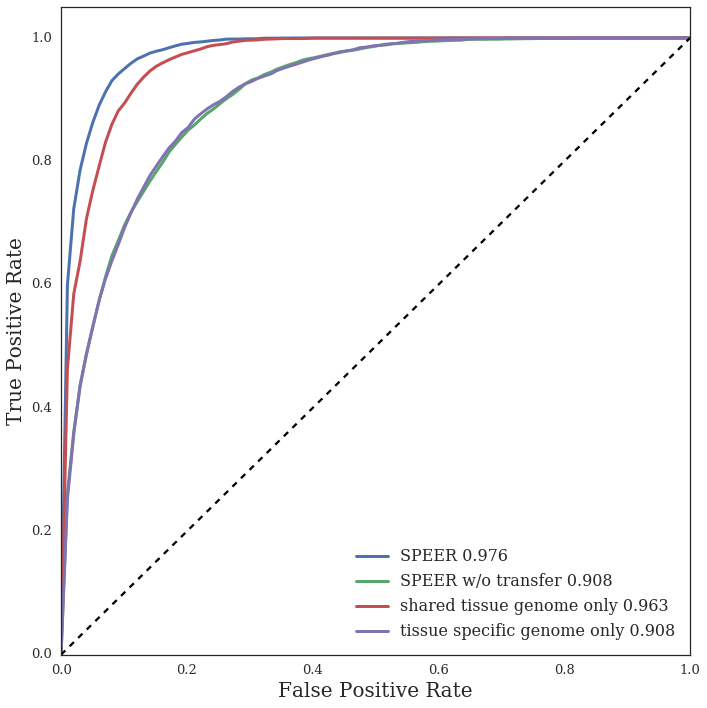

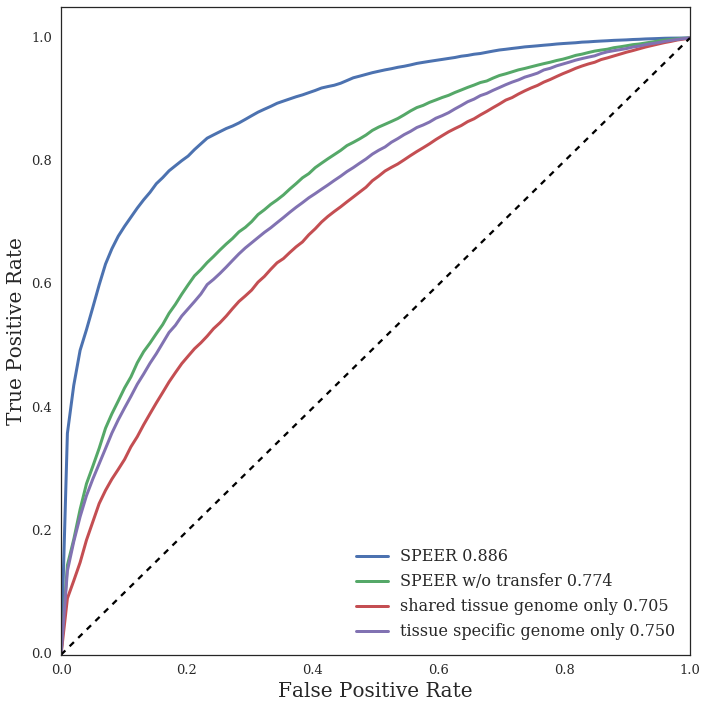

In [17]:
simulation_settings = ['independent', 'tied']
scenarios = ['stronger', 'equal', 'weaker']
models = ['SPEER', 'SPEER_no_transfer', 'RIVER']
%matplotlib inline
for setting in simulation_settings:
    for scenario in scenarios:
        train = {}
        test = {}
        #speer, speer_no_transfer, river = [], [], []
        directory = '../simulated_data/' + setting + '_' + scenario + '_effects/'
        for model in models:
            train[model] = pd.read_csv(str(directory + model + '/train.csv'))
            test[model] = pd.read_csv(directory + model + '/test.csv')
        test['RIVER'] = shared_tissue_genome_only(train['RIVER'], test['RIVER'])
        test['SPEER'] = tissue_specific_genome_only(train['SPEER'], test['SPEER'])
        fpr, tpr, auc = create_roc_curves(test['SPEER'], test['SPEER_no_transfer'], test['RIVER'])
        s = setting+'_'+scenario
        plot_roc_curves(fpr, tpr, auc, directory, s)

In [3]:
def shared_tissue_genome_only(river_train, river_test):
    # shared genomic annotations only model
    genomic_features = river_train.columns[1:-5]
    # train
    beta = lr.sgd(river_train[genomic_features].values, river_train["expr_label"].values, 
                  np.zeros(len(genomic_features)), np.zeros(len(genomic_features)), 0.01)
    # predict on test data
    river_test["shared_genome_only"] = np.exp(lr.log_prob(river_test[genomic_features].values, beta))
    return river_test

In [4]:
def tissue_specific_genome_only(multitask_train, multitask_test):
    genomic_features = multitask_train.columns[1:-5]
    # tissue-specific genomic annotations only model
    tissues = ['brain', 'digestive', 'muscle', 'group1', 'epithelial']
    multitask_test["shared_genome_only"] = -1
    for tissue in tissues:
        tl_train_t = multitask_train[multitask_train["tissue"] == tissue]
        tl_test_t = multitask_test[multitask_test["tissue"] == tissue]
        # train on tissue-specific expression labels and genomic annotations
        beta = lr.sgd(tl_train_t[genomic_features].values, tl_train_t["expr_label"].values, 
                  np.zeros(len(genomic_features)), np.zeros(len(genomic_features)), 0.01)
        # predict on tissue-specific test data
        multitask_test.loc[multitask_test["tissue"] == tissue, "tissue_specific_genome_only"]= np.exp(lr.log_prob(tl_test_t[genomic_features].values, beta))
    return multitask_test

In [18]:
def create_roc_curves(multitask_test, individualtasks_test, river_test):

    tissues = ['brain', 'digestive', 'muscle', 'group1', 'epithelial']
    models = ['SPEER', 'SPEER w/o transfer', 'RIVER', 'shared tissue genome only', 'tissue specific genome only']
    
    shared_models = ['RIVER', 'shared tissue genome only']
    shared_models_headings = ['posterior', 'shared_genome_only']
    
    ts_models = ['SPEER', 'SPEER w/o transfer', 'tissue specific genome only']
    ts_models_data = [multitask_test, individualtasks_test, multitask_test]
    ts_models_headings = ['posterior', 'posterior', 'tissue_specific_genome_only']
    fpr, tpr, auc = {}, {}, {}
    for tissue in tissues:
        fpr[tissue], tpr[tissue], auc[tissue] = {}, {}, {}
    for tissue in tissues:   
        for i in range(len(ts_models)):
            model = ts_models[i]
            data = ts_models_data[i][ts_models_data[i]["tissue"] == tissue]
            heading = ts_models_headings[i]
            fpr[tissue][model], tpr[tissue][model], _ = metrics.roc_curve(data["z_labels"], data[heading])
            auc[tissue][model] = metrics.auc(fpr[tissue][model], tpr[tissue][model])


        for i in range(len(shared_models)):
            data = multitask_test[multitask_test["tissue"] == tissue]
            model = shared_models[i]
            heading = shared_models_headings[i]
            fpr[tissue][model], tpr[tissue][model], _ = metrics.roc_curve(data["z_labels"], river_test[heading])
            auc[tissue][model] = metrics.auc(fpr[tissue][model], tpr[tissue][model])

    # compute average ROC curve across tissues by linear interpolation   
    fpr['average'], tpr['average'], auc['average'] = {}, {}, {}
    #for model in models:
    for model in models:
        mean_tpr = 0.0
        mean_fpr = np.linspace(0,1,100)
        for tissue in tissues:
            mean_tpr += interp(mean_fpr, fpr[tissue][model], tpr[tissue][model])
            mean_tpr[0] = 0.0
        mean_tpr /= len(tissues)
        mean_tpr[-1] = 1.0
        fpr['average'][model] = mean_fpr
        tpr['average'][model] = mean_tpr
        auc['average'][model] = metrics.auc(mean_fpr, mean_tpr)
    return fpr, tpr, auc

In [16]:
def plot_roc_curves(fpr, tpr, auc, directory, s):

    # create ROC curves for each tissue group
    tissues = ['brain', 'digestive', 'muscle', 'group1', 'epithelial']
    tasks = tissues + ['average']
    avg_task = ['average']
    for task in avg_task:
        #models = ['SPEER', 'SPEER w/o transfer', 'RIVER', 'shared tissue genome only', 'tissue specific genome only']
        models = ['SPEER', 'SPEER w/o transfer', 'shared tissue genome only', 'tissue specific genome only']
        
        #models = ['transfer learning', 'no transfer learning',  'tissue specific genome only']

        fig = plt.figure(figsize=(10,10))
        plt.style.use('seaborn-talk')
        for model in models:
            ax = plt.plot(fpr[task][model], tpr[task][model], label=model + ' {0:0.3f}'
                     ''.format(auc[task][model]), linewidth=3)
        ax = plt.plot([0,1], [0,1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=20)
        sns.set_context("paper")
        sns.set_palette("deep")
        sns.set(font='serif')
        sns.set_style("white", {"font.family": "serif", "font.serif": ["Times", "Palatino", "serif"]})
        #ax.spines['top'].set_visible(False)
        #ax.spines['right'].set_visible(False)
        plt.ylabel('True Positive Rate', fontsize=20)
        #plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right", frameon=False, prop={'size':16})
        plt.tight_layout()
        #plt.savefig(directory + '/aggregate.png')
        plt.savefig(directory + '/aggregate_noriver.png', format='png', dpi=200)